In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn-deep')

We read the preprocessed data from the tweets:

In [3]:
df_train = pd.read_csv('ready_to_train.csv')
df_test = pd.read_csv('ready_to_test.csv')

In [4]:
df_train.head()

,Unnamed: 0,user_id,Unnamed: 0.1,num_hashtags,num_urls,num_mentions,is_reply,hahahaha,http,game,...,yeah,fuck,unfollow,haha,para,lmao,nigga,hahaha,cute,ans
0,0,755116,103224.500000,0.039987,0.120921,0.968650,0.526232,0.00064,0.227767,0.009277,...,0.027511,0.181382,0.000000,0.004159,0.000000,0.0,0.000000,0.002559,0.000320,0.0
1,1,755746,106401.500000,0.270136,0.462515,0.680607,0.347274,0.00000,0.406444,0.001859,...,0.012701,0.000620,0.000000,0.002478,0.007125,0.0,0.000000,0.000620,0.003717,0.0
2,2,785080,109608.000000,0.051491,0.064364,0.786185,0.433281,0.00000,0.095133,0.008163,...,0.021664,0.021350,0.000942,0.000628,0.000000,0.0,0.000314,0.000314,0.001256,0.0
3,3,806585,112772.000000,0.086542,0.102768,1.204582,0.762011,0.00000,0.118676,0.001591,...,0.003500,0.004454,0.001591,0.000000,0.000636,0.0,0.000000,0.000318,0.000955,0.0
4,4,806975,115944.400501,0.202131,0.359762,0.827954,0.348480,0.00000,0.413977,0.010655,...,0.001567,0.001567,0.001567,0.000000,0.003761,0.0,0.000000,0.000000,0.000000,0.0


Remove the features that would mess up with the models:

In [5]:
df_train.drop(['Unnamed: 0', 'Unnamed: 0.1', 'user_id', 'num_urls'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0', 'Unnamed: 0.1', 'user_id', 'num_urls', 'lang'], axis=1, inplace=True)

Split it into X and y:

In [6]:
X_train = df_train.drop('ans', axis=1)
y_train = df_train['ans']
X_test = df_test.drop('ans', axis=1)
y_test = df_test['ans']

# Exploring tweets data

In [7]:
train_cor = X_train.corrwith(y_train)
strong_feats = train_cor[train_cor.abs() > 0.4]

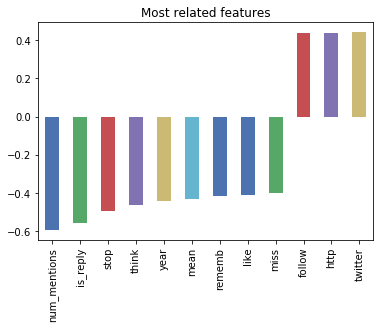

In [8]:
ax = strong_feats.sort_values().plot.bar()
ax.set_title('Most related features')
plt.savefig('Most_related_features.png')

The features num_mentions, which is the mean of mentions made by each user, is_reply, which is the mean of tweets that are replies, and http, which is the mean of links by tweet for the user are most correlated features with the user being a bot or a genuine user

The words more correlated with the user being bot or genuine are: twitter, follow, stop, think, year, mean, remenb, like and miss

The distributions of the most correlated features with the user being a bot or a genuine are:


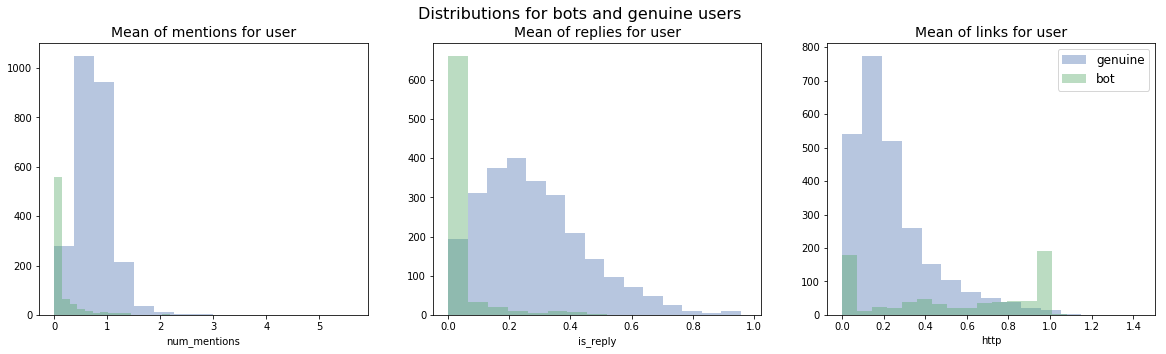

In [9]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

fig.suptitle('Distributions for bots and genuine users', fontsize=16)

sns.distplot(X_train[y_train==0]['num_mentions'], kde=False, bins=15, ax=ax[0], label='genuine')
sns.distplot(X_train[y_train==1]['num_mentions'], kde=False, bins=15, ax=ax[0], label='bot')
ax[0].set_title('Mean of mentions for user', fontsize=14)

sns.distplot(X_train[y_train==0]['is_reply'], kde=False, bins=15, ax=ax[1], label='genuine')
sns.distplot(X_train[y_train==1]['is_reply'], kde=False, bins=15, ax=ax[1], label='bot')
ax[1].set_title('Mean of replies for user', fontsize=14)

sns.distplot(X_train[y_train==0]['http'], kde=False, bins=15, ax=ax[2], label='genuine')
sns.distplot(X_train[y_train==1]['http'], kde=False, bins=15, ax=ax[2], label='bot')
ax[2].set_title('Mean of links for user', fontsize=14)

ax[2].legend(loc='best', fontsize=12)

plt.savefig('Feature_distributions.png')

# Fitting models with all of the features

## Logistic regression:

We start creating a simple Logistic Regression model to classification whether an account is genuine or a bot.

In [10]:
logistic_reg_model = LogisticRegression(max_iter=100000).fit(X_train, y_train)

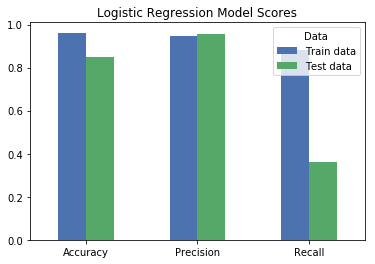

In [11]:
logreg_metrics_dic = {'Metric': ['Accuracy', 'Precision', 'Recall'],
        'Train data': [logistic_reg_model.score(X_train, y_train),
                    metrics.precision_score(y_train, logistic_reg_model.predict(X_train)),
                    metrics.recall_score(y_train, logistic_reg_model.predict(X_train))],
        'Test data': [logistic_reg_model.score(X_test, y_test),
                    metrics.precision_score(y_test, logistic_reg_model.predict(X_test)),
                    metrics.recall_score(y_test, logistic_reg_model.predict(X_test))]}

logreg_metrics = pd.DataFrame(data=logreg_metrics_dic, 
                        columns=['Metric','Train data','Test data'])

fig, ax = plt.subplots()

logreg_metrics.plot.bar(ax=ax)

ax.set_title('Logistic Regression Model Scores')
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax.legend(title='Data')

plt.savefig('Logistic_regression_model_scores.png')

In [12]:
logreg_metrics.set_index('Metric').T.rename_axis(None, 1)

,Accuracy,Precision,Recall
Train data,0.962087,0.945792,0.884000
Test data,0.851277,0.957447,0.361446


## Logistic Regression with Scalarization 


Next, we scalarize all the features and fit another Logistic Regression.

In [13]:
scaler = MinMaxScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

Next, we scalarize all the features using MinMaxScaler from sklearn and fit another Logistic Regression with those values.

In [15]:
logistic_reg_model_sc = LogisticRegression(max_iter=100000).fit(X_train_sc, y_train)

It results in:

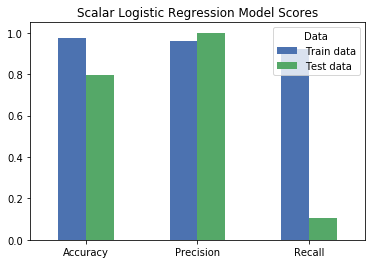

In [16]:
logregsc_metrics_dic = {'Metric': ['Accuracy', 'Precision', 'Recall'],
        'Train data': [logistic_reg_model_sc.score(X_train_sc, y_train),
                    metrics.precision_score(y_train, logistic_reg_model_sc.predict(X_train_sc)),
                    metrics.recall_score(y_train, logistic_reg_model_sc.predict(X_train_sc))],
        'Test data': [logistic_reg_model_sc.score(X_test_sc, y_test),
                    metrics.precision_score(y_test, logistic_reg_model_sc.predict(X_test_sc)),
                    metrics.recall_score(y_test, logistic_reg_model_sc.predict(X_test_sc))]}

logregsc_metrics = pd.DataFrame(data=logregsc_metrics_dic, 
                        columns=['Metric','Train data','Test data'])

fig, ax = plt.subplots()

logregsc_metrics.plot.bar(ax=ax)

ax.set_title('Scalar Logistic Regression Model Scores')
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax.legend(title='Data')

plt.savefig('Scalar_logistic_regression_model_scores.png')

In [17]:
logregsc_metrics.set_index('Metric').T.rename_axis(None, 1)

,Accuracy,Precision,Recall
Train data,0.973309,0.959722,0.921333
Test data,0.796533,1.000000,0.104418


## Random Forest with Scalarization

Our third approach is a random forest classifier with all features scalarized.

In [18]:
rand_for_model = RandomForestClassifier().fit(X_train_sc, y_train)

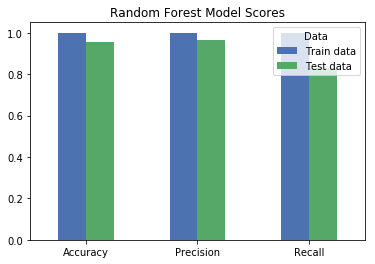

In [19]:
randomf_metrics_dic = {'Metric': ['Accuracy', 'Precision', 'Recall'],
        'Train data': [rand_for_model.score(X_train_sc, y_train),
                    metrics.precision_score(y_train, rand_for_model.predict(X_train_sc)),
                    metrics.recall_score(y_train, rand_for_model.predict(X_train_sc))],
        'Test data': [rand_for_model.score(X_test_sc, y_test),
                    metrics.precision_score(y_test, rand_for_model.predict(X_test_sc)),
                    metrics.recall_score(y_test, rand_for_model.predict(X_test_sc))]}

randomf_metrics = pd.DataFrame(data=randomf_metrics_dic, 
                        columns=['Metric','Train data','Test data'])

fig, ax = plt.subplots()

randomf_metrics.plot.bar(ax=ax)

ax.set_title('Random Forest Model Scores')
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax.legend(title='Data')

plt.savefig('Random_forest_model_scores.png')

In [20]:
randomf_metrics.set_index('Metric').T.rename_axis(None, 1)

,Accuracy,Precision,Recall
Train data,1.00000,1.000000,1.000000
Test data,0.95438,0.962791,0.831325


## Comparison of the models with all features


The metrics gotten with all three models are the following:

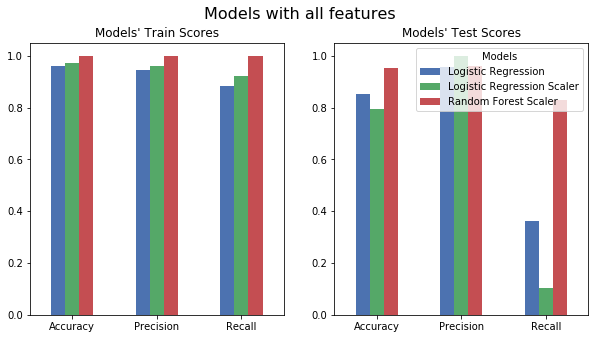

In [21]:
train_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'Logistic Regression': [logistic_reg_model.score(X_train, y_train),
                                metrics.precision_score(y_train, logistic_reg_model.predict(X_train)),
                                metrics.recall_score(y_train, logistic_reg_model.predict(X_train))],
        'Logistic Regression Scaler': [logistic_reg_model_sc.score(X_train_sc, y_train),
                                        metrics.precision_score(y_train, logistic_reg_model_sc.predict(X_train_sc)),
                                        metrics.recall_score(y_train, logistic_reg_model_sc.predict(X_train_sc))],
        'Random Forest Scaler': [rand_for_model.score(X_train_sc, y_train), 
                                metrics.precision_score(y_train, rand_for_model.predict(X_train_sc)),
                                metrics.recall_score(y_train, rand_for_model.predict(X_train_sc))]}

test_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'Logistic Regression': [logistic_reg_model.score(X_test, y_test),
                                metrics.precision_score(y_test, logistic_reg_model.predict(X_test)),
                                metrics.recall_score(y_test, logistic_reg_model.predict(X_test))],
        'Logistic Regression Scaler': [logistic_reg_model_sc.score(X_test_sc, y_test),
                                        metrics.precision_score(y_test, logistic_reg_model_sc.predict(X_test_sc)),
                                        metrics.recall_score(y_test, logistic_reg_model_sc.predict(X_test_sc))],
        'Random Forest Scaler': [rand_for_model.score(X_test_sc, y_test), 
                                metrics.precision_score(y_test, rand_for_model.predict(X_test_sc)),
                                metrics.recall_score(y_test, rand_for_model.predict(X_test_sc))]}

train_metrics = pd.DataFrame(data=train_metrics_dic, 
                            columns=['Metric','Logistic Regression','Logistic Regression Scaler','Random Forest Scaler'])

test_metrics = pd.DataFrame(data=test_metrics_dic, 
                            columns=['Metric','Logistic Regression','Logistic Regression Scaler','Random Forest Scaler'])


fig, ax = plt.subplots(1,2, figsize=(10,5))

fig.suptitle('Models with all features', fontsize=16)

train_metrics.plot.bar(ax=ax[0],legend=False)

ax[0].set_title('Models\' Train Scores')
ax[0].set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)

test_metrics.plot.bar(ax=ax[1])

ax[1].set_title('Models\' Test Scores')
ax[1].set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax[1].legend(title='Models')

plt.savefig('Models_all_features_scores.png')

Between both Logistic Regression models, the one with scalarization had a better performance on all metrics in the training set, but the one without scalarization had better accuracy and recall on the test set.

Comparing the Random Forest with the other models, it had a better performance on the training set than the other two and it also had better accuracy and recall on the test set.

## Fitting model with feature selection from the tweets features


We used the SelectKBest function from sklearn with chi2 to select 10 features out of the 202 initial ones.

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [23]:
featselect = SelectKBest(chi2, k=10).fit(X_train, y_train)
X_train_selected = featselect.transform(X_train)
X_test_selected = featselect.transform(X_test)

In [24]:
mask = featselect.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, list(X_train.columns)):
    if bool:
        new_features.append(feature)

In [25]:
new_features

['num_mentions',
 'is_reply',
 'http',
 'follow',
 'guy',
 'video',
 'check',
 'twitter',
 'para',
 'cute']

The selected feaatures were the mean of mentions made by each user (num_mentions), the mean of tweets that are replies (is_reply), the mean of links by tweet for the user (http) and the mean of the number of times the words follow, guy, video, check, twitter, para and cute were used on the tweets.
Comparing these features with the ones we found with the correlation, we have that almost all of the words selected change, remaining only 'twitter' from the previous set of features..

## Random Forest with Feature Selection


With those selected features, we fit a Random Forest classifier. The data was not scalarized for this model.


In [26]:
rand_for_model_new = RandomForestClassifier().fit(X_train_selected, y_train)

The metrics results we got with this model were:


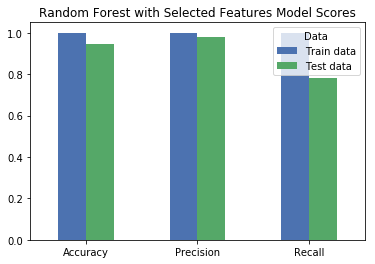

In [27]:
randomf_10_metrics_dic = {'Metric': ['Accuracy', 'Precision', 'Recall'],
        'Train data': [rand_for_model_new.score(X_train_selected, y_train),
                    metrics.precision_score(y_train, rand_for_model_new.predict(X_train_selected)),
                    metrics.recall_score(y_train, rand_for_model_new.predict(X_train_selected))],
        'Test data': [rand_for_model_new.score(X_test_selected, y_test),
                    metrics.precision_score(y_test, rand_for_model_new.predict(X_test_selected)),
                    metrics.recall_score(y_test, rand_for_model_new.predict(X_test_selected))]}

randomf_10_metrics = pd.DataFrame(data=randomf_10_metrics_dic, 
                        columns=['Metric','Train data','Test data'])

fig, ax = plt.subplots()

randomf_10_metrics.plot.bar(ax=ax)

ax.set_title('Random Forest with Selected Features Model Scores')
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax.legend(title='Data')

plt.savefig('Random_forest_selected_model_scores.png')

In [28]:
randomf_10_metrics.set_index('Metric').T.rename_axis(None, 1)

,Accuracy,Precision,Recall
Train data,1.000000,1.000000,1.000000
Test data,0.946168,0.979798,0.779116


## Comparison of the Random Forest models

Comparing the metrics we got we both the Random Forest model with all features and the one with only the 10 selected features, we have: 


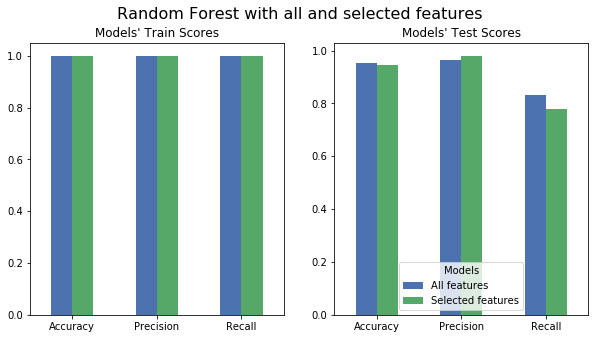

In [29]:
rf_train_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'All features': [rand_for_model.score(X_train_sc, y_train),
                    metrics.precision_score(y_train, rand_for_model.predict(X_train_sc)),
                    metrics.recall_score(y_train, rand_for_model.predict(X_train_sc))],
        'Selected features': [rand_for_model_new.score(X_train_selected, y_train),
                    metrics.precision_score(y_train, rand_for_model_new.predict(X_train_selected)),
                    metrics.recall_score(y_train, rand_for_model_new.predict(X_train_selected))]}

rf_test_metrics_dic = {'Metric': ['Acc', 'Prec', 'Recall'],
        'All features': [rand_for_model.score(X_test_sc, y_test),
                    metrics.precision_score(y_test, rand_for_model.predict(X_test_sc)),
                    metrics.recall_score(y_test, rand_for_model.predict(X_test_sc))],
        'Selected features': [rand_for_model_new.score(X_test_selected, y_test),
                    metrics.precision_score(y_test, rand_for_model_new.predict(X_test_selected)),
                    metrics.recall_score(y_test, rand_for_model_new.predict(X_test_selected))]}

rf_train_metrics = pd.DataFrame(data=rf_train_metrics_dic, 
                            columns=['Metric','All features','Selected features'])

rf_test_metrics = pd.DataFrame(data=rf_test_metrics_dic, 
                            columns=['Metric','All features','Selected features'])


fig, ax = plt.subplots(1,2, figsize=(10,5))

fig.suptitle('Random Forest with all and selected features', fontsize=16)

rf_train_metrics.plot.bar(ax=ax[0],legend=False)

ax[0].set_title('Models\' Train Scores')
ax[0].set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)

rf_test_metrics.plot.bar(ax=ax[1])

ax[1].set_title('Models\' Test Scores')
ax[1].set_xticklabels(['Accuracy', 'Precision', 'Recall'], rotation=0)
ax[1].legend(title='Models')

plt.savefig('Random_forest_models_scores.png')

On the training set, both models had similar results and on the test set their performance was practically the same on the accuracy, with the one with selected features having a better precision, but worse recall. Overall, both had good and similar results.